<a href="https://colab.research.google.com/github/revanth2802/ecommerce_DS/blob/main/ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Replace 'file_path' with the path to your dataset file
file_path = '/content/drive/MyDrive/ColabNotebooks/data.csv'
data = pd.read_csv(file_path, encoding='unicode_escape')


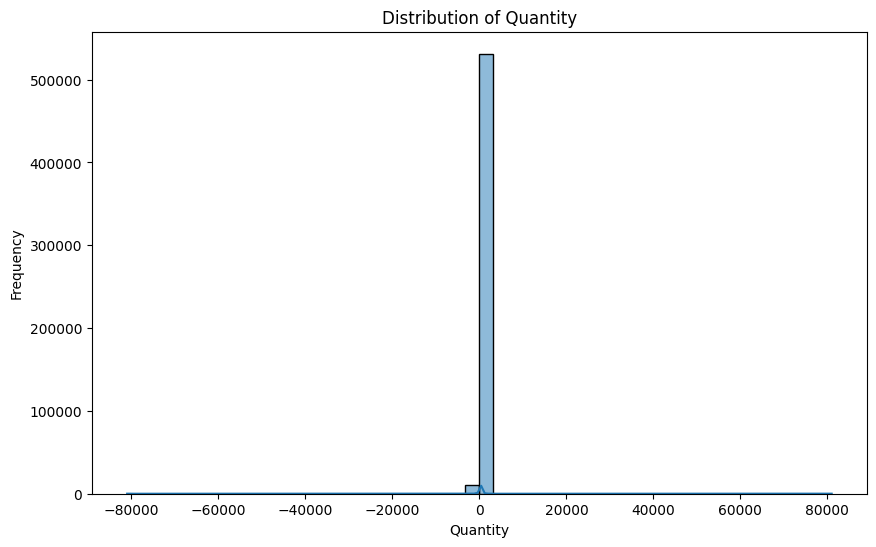

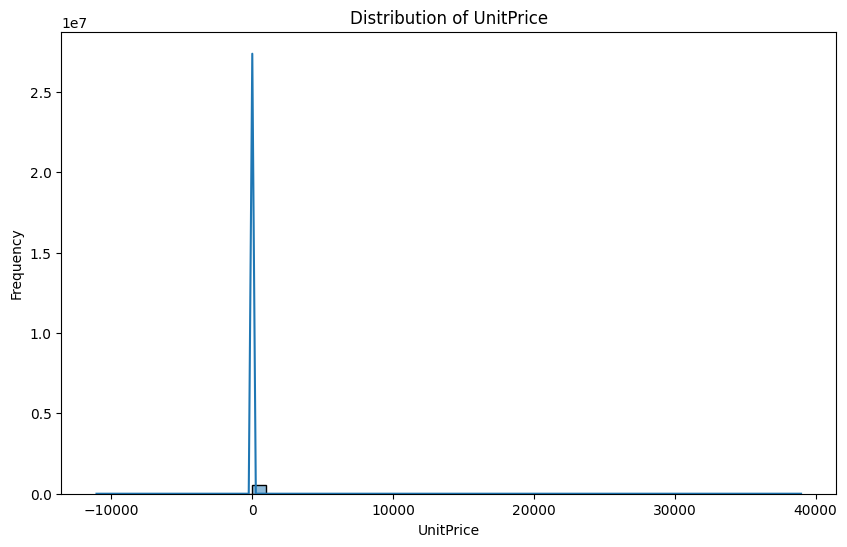

In [ ]:
# Display the first few rows of the dataset
data.head()

# Check the shape of the dataset
data.shape

# Check for missing values
data.isnull().sum()

# Summary statistics
data.describe()

# Visualize the distribution of Quantity and UnitPrice
plt.figure(figsize=(10, 6))
sns.histplot(data['Quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['UnitPrice'], bins=50, kde=True)
plt.title('Distribution of UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# data pre preprocessing

In [ ]:
# Check for missing values again
data.isnull().sum()

# Remove rows with missing CustomerID, as they are not useful for recommendation
data = data.dropna(subset=['CustomerID'])

In [ ]:
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract date-related features
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Hour'] = data['InvoiceDate'].dt.hour
data['Weekday'] = data['InvoiceDate'].dt.weekday

# Calculate total sales (Quantity * UnitPrice) for each transaction
data['TotalSales'] = data['Quantity'] * data['UnitPrice']

In [ ]:
# Filter out cancelled orders (negative Quantity)
data = data[data['Quantity'] > 0]

In [ ]:
# Remove outliers based on TotalSales
q1 = data['TotalSales'].quantile(0.25)
q3 = data['TotalSales'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data = data[(data['TotalSales'] >= lower_bound) & (data['TotalSales'] <= upper_bound)]

In [ ]:
# Encode categorical variables (e.g., Country)
data = pd.get_dummies(data, columns=['Country'], drop_first=True)

In [ ]:
# Display the first few rows of the preprocessed dataset
data.head()

# Check the shape of the preprocessed dataset
data.shape

(366683, 49)

In [ ]:
# Building Recommended Models

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162984 sha256=9673f9b14f8268eb218b1265e9cc482debf4e0c1f976e0cf47103dcfd25b211c
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic, accuracy

# Load data
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data.csv', encoding='unicode_escape')

# Create Surprise Reader object
reader = Reader(rating_scale=(data['Quantity'].min(), data['Quantity'].max()))

# Load data into Surprise Dataset
data_surprise = Dataset.load_from_df(data[['CustomerID', 'StockCode', 'Quantity']], reader)

# Split data into training and testing sets
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)

# Build and train KNNBasic collaborative filtering model
model_cf = KNNBasic(sim_options={'user_based': False})  # Item-based CF
model_cf.fit(trainset)

# Make predictions on the test set
predictions_cf = model_cf.test(testset)

# Evaluate the model
accuracy.rmse(predictions_cf)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 493.2088


493.2088470454463

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd

# Make sure to load your data into a pandas DataFrame
# Replace 'recipe_data.csv' with your actual dataset file
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data.csv', encoding='latin-1')

# Drop rows with missing descriptions
data.dropna(subset=['Description'], inplace=True)

# Create TF-IDF vectorizer for item descriptions
tfidf = TfidfVectorizer(stop_words='english')
item_descriptions = data.groupby('StockCode')['Description'].unique().str.join(' ')
tfidf_matrix = tfidf.fit_transform(item_descriptions)

# Compute cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create a mapping of StockCode to index in the vectorized matrix
indices = dict(zip(item_descriptions.index, range(len(item_descriptions))))

# Function to recommend items based on similarity
def recommend_items_content_based(stock_code, cosine_sim=cosine_sim):
    idx = indices.get(stock_code)
    if idx is None:
        print(f"StockCode '{stock_code}' not found in dataset.")
        return []
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    stock_codes = [i[0] for i in sim_scores]
    return data['Description'].iloc[stock_codes]

# Example: recommend items similar to a given StockCode
recommendations = recommend_items_content_based('22632')
print(recommendations)


2285                CHRISTMAS GINGHAM HEART
1737         IVORY PILLAR CANDLE GOLD FLOCK
1707           HOMEMADE JAM SCENTED CANDLES
1735      SET OF 6 HALLOWEEN GHOST T-LIGHTS
1513       PARTY CONE CHRISTMAS DECORATION 
1736       IVORY PILLAR CANDLE SILVER FLOCK
2746                   MINI JIGSAW SPACEBOY
612     FOLDING UMBRELLA RED/WHITE POLKADOT
3483           COFFEE MUG CAT + BIRD DESIGN
2078                  RECIPE BOX RETROSPOT 
Name: Description, dtype: object
